# Predict Titanic Survival

The main goal is to pre-process the data as good as you can, select the right techniques and obtain a good score. The main idea behind the competition is to come
up with a model to predict whether someone survived the Titanic disaster or not based on a training set of people for whom you know whether they survived or not.

# Exploration phase

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Initialize dataframe
df = pd.read_csv('./data/train.csv')
# Show first 5 rows
df.head()
# Survived is target label, 0 = deceased and 1 = survived

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Text(0.5, 1.0, 'Visual demonstration of missing values in "training" dataset')

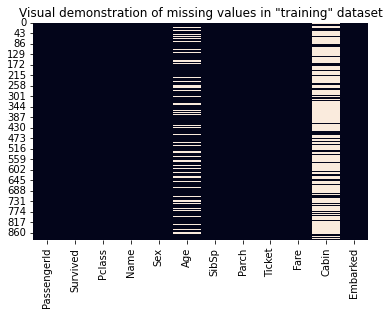

In [3]:
"""This could be used to visually demonstrate (in the report) how important it was to predict the age groups of passangers."""
sns.heatmap(df.isnull(), cbar = False).set_title('Visual demonstration of missing values in "training" dataset')


In [4]:
print('Total rows: {}'.format(df.shape[0]))

Total rows: 891


In [5]:
print('Missing values:')
print(df.isna().sum())

Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [6]:
print('Unique values per feature:')
print(df.nunique())

Unique values per feature:
PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


In [7]:
# Data cleanup (should be seperate function eventually)

# Function from https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    print(big_string)
    return np.nan

def data_cleanup(df):

    # # Drop PassengerID
    # df = df.drop(['PassengerId'],axis=1)

    # name turn to title
    # coded with help of https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
    # ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Mlle', 'Col' 'Capt' 'Countess' 'Jonkheer']
    # [11 12  8  7  3 14  4 10 13  6  9  1  0  2  5]
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                        'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                        'Don', 'Jonkheer']
    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))
    # Title will be turned into unique label integer
    df['Title'] = LabelEncoder().fit_transform(df['Title'])
    # Name will be dropped 
    df = df.drop(['Name'],axis=1)

    # Sex should be turned into unique integer label, 0 or 1
    # Sex, 0 = female and 1 = male
    df['Sex'] = LabelEncoder().fit_transform(df['Sex'])

    # ticket (Ticket number) not sure if this is very informative? Suggestion to drop it (Pclass and fare are more informative)
    df = df.drop(['Ticket'],axis=1)

    # cabin (number), 687 missing values (77%). I suggest leaving this feature out, due to its absence in training set (Pclass and fare might depict what kind of cabin better)
    df = df.drop(['Cabin'],axis=1)

    # embarked should be turned into unique integer label, 0 = C (Cherbourgh), 1 = Q (Queenstown), 2 = S (Southampton)
    df.Embarked.fillna('C', inplace=True)
    df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])
    return df

df = data_cleanup(df)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,1,22.0,1,0,7.2500,2,11
1,2,1,1,0,38.0,1,0,71.2833,0,12
2,3,1,3,0,26.0,0,0,7.9250,2,8
3,4,1,1,0,35.0,1,0,53.1000,2,12
4,5,0,3,1,35.0,0,0,8.0500,2,11


In [8]:
# Print amount males and females
print(df.Sex.value_counts())
# Sex, 0 = female and 1 = male

1    577
0    314
Name: Sex, dtype: int64


Sex  Survived
0    1           233
     0            81
1    0           468
     1           109
Name: Survived, dtype: int64


<AxesSubplot:xlabel='Sex'>

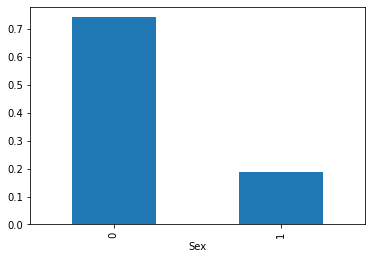

In [9]:
# Relation male/female and survived
print(df.groupby('Sex').Survived.value_counts())
df.groupby('Sex').Survived.mean().plot(kind='bar')
# Survived is target label, 0 = deceased and 1 = survived
# Sex, 0 = female and 1 = male

In [10]:
# Plot fare
print(df['Fare'].describe())

print(df.loc[df['Fare'] == 0])
print(df.loc[df['Fare'] == 0].size)

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64
     PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch  Fare  Embarked  \
179          180         0       3    1  36.0      0      0   0.0         2   
263          264         0       1    1  40.0      0      0   0.0         2   
271          272         1       3    1  25.0      0      0   0.0         2   
277          278         0       2    1   NaN      0      0   0.0         2   
302          303         0       3    1  19.0      0      0   0.0         2   
413          414         0       2    1   NaN      0      0   0.0         2   
466          467         0       2    1   NaN      0      0   0.0         2   
481          482         0       2    1   NaN      0      0   0.0         2   
597          598         0       3    1  49.0      0      0   0.0         2   
633          634       

In [11]:
# AGE PREDICTOR EXPERIMENT
df_1 = pd.read_csv('./data/train.csv')
df_2 = pd.read_csv('./data/test.csv')

# Ready df_1
df_1 = df_1.loc[df_1.Age.notnull()]
df_1.drop(['Survived'],axis=1, inplace=True)
df_1 = data_cleanup(df_1)
print(df_1.shape[0])
# Ready df_2
df_2 = df_2.loc[df_2.Age.notnull()]
df_2 = df_2.loc[df_2.Fare.notnull()]
df_2 = data_cleanup(df_2)
print(df_2.shape[0])

new_df = pd.concat([df_1, df_2], axis=0)

print(new_df.head())
print(new_df.shape[0])

print('Unique values per feature:')
print(new_df.nunique())

print('Missing values:')
print(new_df.isna().sum())

new_df.corr(method='pearson')


714
331
   PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title
0            1       3    1  22.0      1      0   7.2500         2     11
1            2       1    0  38.0      1      0  71.2833         0     12
2            3       3    0  26.0      0      0   7.9250         2      8
3            4       1    0  35.0      1      0  53.1000         2     12
4            5       3    1  35.0      0      0   8.0500         2     11
1045
Unique values per feature:
PassengerId    1045
Pclass            3
Sex               2
Age              97
SibSp             7
Parch             7
Fare            256
Embarked          3
Title            15
dtype: int64
Missing values:
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,1.000000,-0.065086,-0.000156,0.026792,-0.050189,-0.020615,0.047938,-0.063707,-0.668438
Pclass,-0.065086,1.000000,0.144105,-0.411086,0.047746,0.017685,-0.565255,0.280274,0.056142
Sex,-0.000156,0.144105,1.000000,0.062235,-0.094902,-0.220864,-0.187930,0.113614,0.095851
Age,0.026792,-0.411086,0.062235,1.000000,-0.243139,-0.150241,0.178740,-0.087878,0.158041
SibSp,-0.050189,0.047746,-0.094902,-0.243139,1.000000,0.374291,0.141184,0.047351,-0.090327
Parch,-0.020615,0.017685,-0.220864,-0.150241,0.374291,1.000000,0.216723,0.013017,-0.040694
Fare,0.047938,-0.565255,-0.187930,0.178740,0.141184,0.216723,1.000000,-0.303069,-0.086668
Embarked,-0.063707,0.280274,0.113614,-0.087878,0.047351,0.013017,-0.303069,1.000000,0.100735
Title,-0.668438,0.056142,0.095851,0.158041,-0.090327,-0.040694,-0.086668,0.100735,1.000000


count    1045.000000
mean       29.851837
std        14.389194
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


<AxesSubplot:>

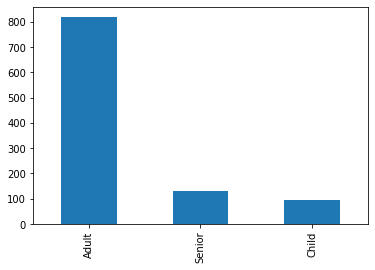

In [12]:
# According to the correlation schema, correlation between Age and Sex/Embarked is negligble so leaving them out
new_df.drop(['Embarked', 'Sex'],axis=1, inplace=True)
# Describe Age ranges
print(new_df['Age'].describe())

# Age groups, need to figure out class balance 
bins= [0, 13, 48, 110]
labels = ['Child', 'Adult', 'Senior']
new_df['AgeGroup'] = pd.cut(new_df['Age'], bins=bins, labels=labels, right=False)

new_df['AgeGroup'].value_counts().plot(kind='bar')

In [13]:
new_df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Title,AgeGroup
0,1,3,22.0,1,0,7.2500,11,Adult
1,2,1,38.0,1,0,71.2833,12,Adult
2,3,3,26.0,0,0,7.9250,8,Adult
3,4,1,35.0,1,0,53.1000,12,Adult
4,5,3,35.0,0,0,8.0500,11,Adult


In [14]:
# Evaluating two models, CategoricalNaiveBayes and CategoricalDecisionTree - EVALUATED, chosen for RandomForestClassifier

# First drop age
new_df.drop(['Age'],axis=1, inplace=True)
# Turn AgeGroup into unique label integer
print(new_df['AgeGroup'].unique())
new_df['AgeGroup'] = LabelEncoder().fit_transform(new_df['AgeGroup'])
print(new_df['AgeGroup'].unique())
# Double check df
print(new_df.head())

# Preparing data 
X_exp = new_df.iloc[:,0:6] 
y_exp = new_df.iloc[:, 6]
X_exp.head(), y_exp.head()

# To counteract the class imbalance

# Random oversampler
ros = RandomOverSampler(random_state=0)
X_exp, y_exp = ros.fit_resample(X_exp, y_exp)
# SMOTE oversampler
# smote = SMOTE()
# X_exp, y_exp = smote.fit_resample(X_exp, y_exp)

# Initialize models
rfc_e = RandomForestClassifier(criterion='entropy')
rfc_g = RandomForestClassifier(criterion='gini')
# cnb = CategoricalNB(min_categories=X_exp.nunique() + 2)


['Adult', 'Senior', 'Child']
Categories (3, object): ['Child' < 'Adult' < 'Senior']
[0 2 1]
   PassengerId  Pclass  SibSp  Parch     Fare  Title  AgeGroup
0            1       3      1      0   7.2500     11         0
1            2       1      1      0  71.2833     12         0
2            3       3      0      0   7.9250      8         0
3            4       1      1      0  53.1000     12         0
4            5       3      0      0   8.0500     11         0


In [15]:
# Cross-validate (stratified k fold) scores each model
scores_rfc_e = cross_val_score(rfc_e, X_exp, y_exp, cv=5)
scores_rfc_g = cross_val_score(rfc_g, X_exp, y_exp, cv=5)
# scores_cnb = cross_val_score(cnb, X_exp, y_exp, cv=5)

print("rfc_e %0.2f accuracy with a standard deviation of %0.2f" % (scores_rfc_e.mean(), scores_rfc_e.std()))
print("rfc_g %0.2f accuracy with a standard deviation of %0.2f" % (scores_rfc_g.mean(), scores_rfc_g.std()))
# print("cnb %0.2f accuracy with a standard deviation of %0.2f" % (scores_cnb.mean(), scores_cnb.std()))

pred_rfc_e = cross_val_predict(rfc_e, X_exp, y_exp, cv=5)
pred_rfc_g = cross_val_predict(rfc_g, X_exp, y_exp, cv=5)
# pred_cnb = cross_val_predict(cnb, X_exp, y_exp, cv=5)

print(classification_report(y_exp, pred_rfc_e))
#ConfusionMatrixDisplay.from_predictions(y_exp, pred_rfc_e)

print(classification_report(y_exp, pred_rfc_g))
#ConfusionMatrixDisplay.from_predictions(y_exp, pred_rfc_g)

# print(classification_report(y_exp, pred_cnb))
# ConfusionMatrixDisplay.from_predictions(y_exp, pred_cnb)


rfc_e 0.80 accuracy with a standard deviation of 0.04
rfc_g 0.80 accuracy with a standard deviation of 0.05
              precision    recall  f1-score   support

           0       1.00      0.40      0.57       819
           1       0.94      1.00      0.97       819
           2       0.65      1.00      0.79       819

    accuracy                           0.80      2457
   macro avg       0.86      0.80      0.78      2457
weighted avg       0.86      0.80      0.78      2457

              precision    recall  f1-score   support

           0       1.00      0.38      0.55       819
           1       0.95      1.00      0.97       819
           2       0.64      1.00      0.78       819

    accuracy                           0.79      2457
   macro avg       0.86      0.79      0.77      2457
weighted avg       0.86      0.79      0.77      2457



In [16]:
# Show rows of original train df that does not have age
ageless_df = df[df['Age'].isnull()]
ageless_df.drop(['Survived', 'Embarked', 'Sex', 'Age'],axis=1, inplace=True)
print(ageless_df.tail())
# Fit chosen model with our data
rfc_g.fit(X_exp, y_exp)
# Predict 
predict_age = rfc_g.predict(ageless_df)

print(predict_age)
print(ageless_df.index)


/var/folders/fb/8nfqdx5j53xgdm6bl0rll2mc0000gn/T/ipykernel_90623/70931193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ageless_df.drop(['Survived', 'Embarked', 'Sex', 'Age'],axis=1, inplace=True)


     PassengerId  Pclass  SibSp  Parch     Fare  Title
859          860       3      0      0   7.2292     11
863          864       3      8      2  69.5500      8
868          869       3      0      0   9.5000     11
878          879       3      0      0   7.8958     11
888          889       3      1      2  23.4500      8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 2 1 0 0
 0 0 2 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 2 0 0 2 0 0 0 2 1 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0
 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)


In [17]:
# Plug values into df
print(type(predict_age))
df.loc[ageless_df.index, 'AgeGroup'] = predict_age
# print(df.loc[ageless_df.index])
# Turn existing ages into agegroups
bins= [0, 13, 48, 110]
labels = [0, 2, 1]

m = df['AgeGroup'].isna()
df.loc[m, 'AgeGroup'] = pd.cut(df[df['AgeGroup'].isnull()]['Age'], bins=bins, labels=labels, right=False).to_numpy()
df['AgeGroup'] = df['AgeGroup'].astype(int)
# Drop the Age feature
df.drop(['Age'],axis=1, inplace=True)
print(df)

<class 'numpy.ndarray'>
     PassengerId  Survived  Pclass  Sex  SibSp  Parch     Fare  Embarked  \
0              1         0       3    1      1      0   7.2500         2   
1              2         1       1    0      1      0  71.2833         0   
2              3         1       3    0      0      0   7.9250         2   
3              4         1       1    0      1      0  53.1000         2   
4              5         0       3    1      0      0   8.0500         2   
..           ...       ...     ...  ...    ...    ...      ...       ...   
886          887         0       2    1      0      0  13.0000         2   
887          888         1       1    0      0      0  30.0000         2   
888          889         0       3    0      1      2  23.4500         2   
889          890         1       1    1      0      0  30.0000         0   
890          891         0       3    1      0      0   7.7500         1   

     Title  AgeGroup  
0       11         2  
1       12       

# Working on it from here, fill up later

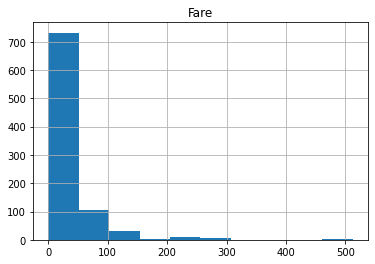

In [18]:
fare_dist = df.hist('Fare')
# think on this later, can something useful be done for the fare feature?


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     891 non-null    int64  
 8   Title        891 non-null    int64  
 9   AgeGroup     891 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 69.7 KB
None


<AxesSubplot:>

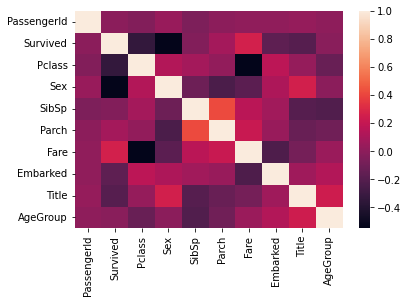

In [19]:
print(df.info())
sns.heatmap(df.corr())

In [20]:
"""Displays the average price paid, family size and number of siblings for both not survived(0) and survived(1). """

pd.pivot_table(df, index= 'Survived', values = ['SibSp', 'Parch', 'Fare'])

# Nothing here is too significant, but:
# This indicates that those who survived payed more
# those who have parents are more likely to survive
# those who have siblings are less likely to survive? 
# I dont think this is too surprising

,Fare,Parch,SibSp
Survived,,,
0,22.117887,0.329690,0.553734
1,48.395408,0.464912,0.473684


## Visualising currently remaining features

<AxesSubplot:title={'center':'How many survived'}>

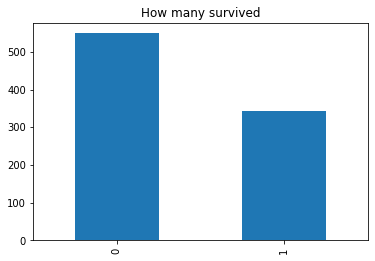

In [21]:
df['Survived'].value_counts().plot.bar(title='How many survived')#####2@@@dfgdfgdfgdfgdfgasdghjghjfghgfhi

<AxesSubplot:title={'center':'How many in each class'}>

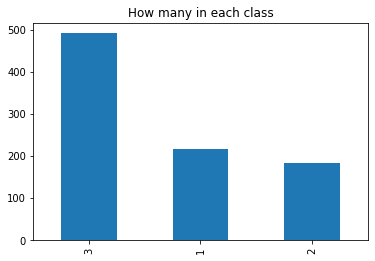

In [22]:
df['Pclass'].value_counts().plot.bar(title='How many in each class')

<AxesSubplot:title={'center':'How many siblings and spouses'}>

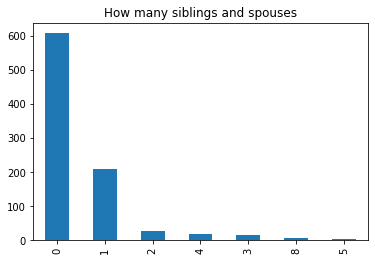

In [23]:
df['SibSp'].value_counts().plot.bar(title='How many siblings and spouses')

<AxesSubplot:title={'center':'How many with parent or children a passanger has'}>

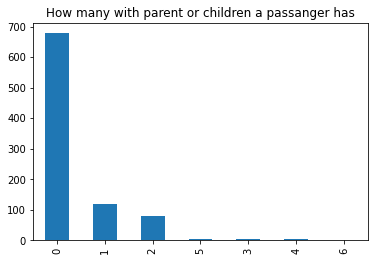

In [24]:
df['Parch'].value_counts().plot.bar(title='How many with parent or children a passanger has')

### Representing how many survived from each class

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

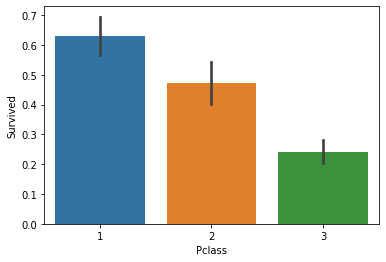

In [25]:
sns.barplot(x='Pclass', y='Survived', data=df)

### For write up - This strongly indicates that survival rates were highly dependant on the passangers class. 

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


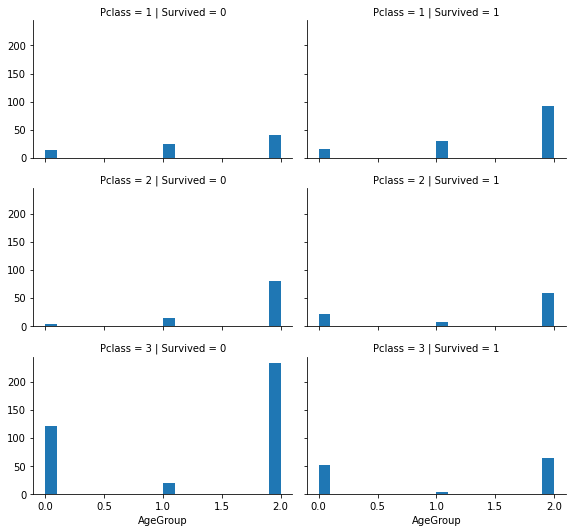

In [26]:
"""The plot below further demonstrates that 1st class passangers were more likely to survive while 3rd class passangers were less likely to survive"""


### ['Child', 'Adult', 'Senior'] are [0, 2, 1]

grid = sns.FacetGrid(df, col='Survived', row='Pclass', size=2.5, aspect=1.6)
grid.map(plt.hist, 'AgeGroup', alpha=1, bins=20)
grid.add_legend()

# Preprocessing
### Combining Siblings/spouses and Parents/childern features to 'Family' column and making an 'alone' category

1    537
0    354
Name: Alone, dtype: int64


/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


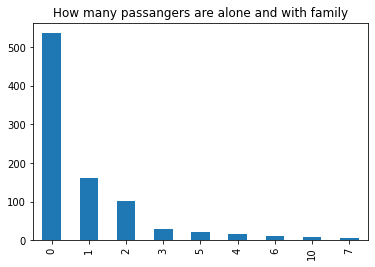

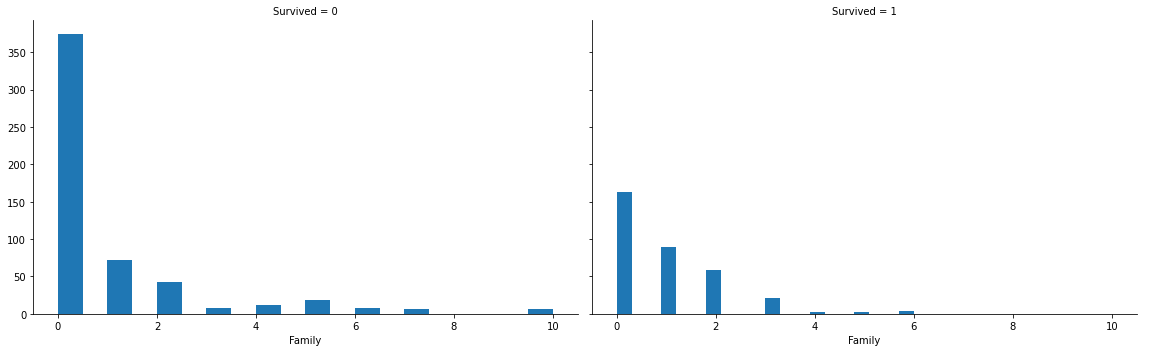

In [27]:
# Making family column with both Parch and SibSp
df['Family'] = df['Parch'] + df['SibSp']

# Making alone category where Family column is 0 and then replacing the booleans with ints 
df['Alone'] = df['Family'] == 0
df['Alone'].replace({False: 0, True: 1}, inplace=True)

# How many in Family and Alone [1=is alone, 0=has family]
print(df['Alone'].value_counts())

# Displaying family sizes
df['Family'].value_counts().plot.bar(title='How many passangers are alone and with family')


# Displaying survivability with family amount, It seems like passangers with < 3 family members are more likely to survive
grid = sns.FacetGrid(df, col='Survived', size=5, aspect=1.6)
grid.map(plt.hist, 'Family', alpha=1, bins=20)
grid.add_legend()

# Dropping both Parch and SibSp columns from df
df = df.drop(['Parch'], axis=1)
df = df.drop(['SibSp'], axis=1)



### To Consider: Should we do something quickly about the fare feature? Turn into categories maybe? 

In [28]:
display(df)
original_df = pd.read_csv('./data/train.csv')
print(df.info())
# print(original_df.corr(method='pearson'))
# print(df.corr(method='pearson'))


,PassengerId,Survived,Pclass,Sex,Fare,Embarked,Title,AgeGroup,Family,Alone
0,1,0,3,1,7.2500,2,11,2,1,0
1,2,1,1,0,71.2833,0,12,2,1,0
2,3,1,3,0,7.9250,2,8,2,0,1
3,4,1,1,0,53.1000,2,12,2,1,0
4,5,0,3,1,8.0500,2,11,2,0,1
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,13.0000,2,14,2,0,1
887,888,1,1,0,30.0000,2,8,2,0,1
888,889,0,3,0,23.4500,2,8,1,3,0
889,890,1,1,1,30.0000,0,11,2,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Fare         891 non-null    float64
 5   Embarked     891 non-null    int64  
 6   Title        891 non-null    int64  
 7   AgeGroup     891 non-null    int64  
 8   Family       891 non-null    int64  
 9   Alone        891 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 69.7 KB
None


### Preparing the data 

In [29]:
# Load in the test.csv
test_df = pd.read_csv('./data/test.csv')
# test = test_df.drop('PassengerId', axis=1) # to avoid error

X_training = df.loc[:, df.columns != 'Survived']
y_training = df['Survived']

# Train test split - 
###The train-test split procedure is used to estimate the performance of machine learning algorithms 
### when they are used to make predictions on data not used to train the model.
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training)


### Initializing the models

In [30]:
# Random Forest 
rfc_e_end = RandomForestClassifier(criterion='entropy')
rfc_g_end = RandomForestClassifier(criterion='gini')
# Stochastic Gradient Descent
sgd = SGDClassifier()
# Gaussian Naive Bayes
gnb = GaussianNB()
# KNN Classifier
KNN = KNeighborsClassifier()
# Logistic Regression classifier
lgc = LogisticRegression(multi_class='multinomial')

In [31]:
# fit models
gnb.fit(X_training, y_training)
KNN.fit(X_training, y_training)
lgc.fit(X_training, y_training)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

### Running the models

In [32]:
### Gaussian Naive Bayes 
gnb_res = cross_val_score(gnb, X_training, y_training)
print(gnb_res)
print(f"gnb {gnb_res.mean()} accuracy with standard diviation of {gnb_res.std()}")

gnb_pred = gnb.predict(X_val)
print(f"gnb accuracy score is : {accuracy_score(y_val, gnb_pred)}")

[0.73743017 0.78651685 0.79213483 0.82022472 0.80337079]
gnb 0.7879354717218003 accuracy with standard diviation of 0.02775347647576841
gnb accuracy score is : 0.8251121076233184


In [33]:
### K-Nearest Neighbours
KNN_res = cross_val_score(KNN, X_training, y_training)
print(KNN_res)
print(f"KNN {KNN_res.mean()} accuracy with standard diviation of {KNN_res.std()}")

KNN_pred = KNN.predict(X_val)
print(f"KNN accuracy score is : {accuracy_score(y_val, KNN_pred)}")

[0.62011173 0.4494382  0.47191011 0.5        0.67977528]
KNN 0.5442470654698387 accuracy with standard diviation of 0.08978029061539171
KNN accuracy score is : 0.7713004484304933


In [34]:
### Logistic regression
lgc_res = cross_val_score(lgc, X_training, y_training)
print(lgc)
print(f"Lgc {lgc_res.mean()} accuracy with standard diviation of {lgc_res.std()}")

lgc_pred = lgc.predict(X_val)
print(f"Lgc accuracy score is : {accuracy_score(y_val, lgc_pred)}")

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LogisticRegression(multi_class='multinomial')
Lgc 0.7856255100119265 accuracy with standard diviation of 0.01406297058650803
Lgc accuracy score is : 0.7802690582959642


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
### Random Forest Classification
scores_rfc_e_end = cross_val_score(rfc_e_end, X_training, y_training, cv=5)
scores_rfc_g_end = cross_val_score(rfc_g_end, X_training, y_training, cv=5)

print(scores_rfc_e_end)
print(scores_rfc_g_end)
print("rfc_e %0.2f accuracy with a standard deviation of %0.2f" % (scores_rfc_e_end.mean(), scores_rfc_e_end.std()))
print("rfc_g %0.2f accuracy with a standard deviation of %0.2f" % (scores_rfc_g_end.mean(), scores_rfc_g_end.std()))

rfc_e_end.fit(X_training, y_training)
rfc_e_pred = rfc_e_end.predict(X_val)
print(f"rfc_e accuracy score is : {accuracy_score(y_val, rfc_e_pred)}")

rfc_g_end.fit(X_training, y_training)
rfc_g_pred = rfc_g_end.predict(X_val)
print(f"rfc_g accuracy score is : {accuracy_score(y_val, rfc_e_pred)}")



[0.75977654 0.79775281 0.84269663 0.83146067 0.83146067]
[0.75977654 0.80337079 0.83146067 0.82022472 0.83707865]
rfc_e 0.81 accuracy with a standard deviation of 0.03
rfc_g 0.81 accuracy with a standard deviation of 0.03
rfc_e accuracy score is : 1.0
rfc_g accuracy score is : 1.0


In [36]:
### Stochastic Gradient Descent
sgd_scores = cross_val_score(sgd, X_training, y_training)
print(sgd_scores)
print(f"sgd {sgd_scores.mean()} accuracy with standard diviation of {sgd_scores.std()}")

sgd.fit(X_training, y_training)
sgd_pred = sgd.predict(X_val)
print(f"sgd accuracy score is : {accuracy_score(y_val, sgd_pred)}")
print(sgd.score(X_training, y_training))


[0.58659218 0.51123596 0.38202247 0.69662921 0.61797753]
sgd 0.5588914694620551 accuracy with standard diviation of 0.10656816419243118
sgd accuracy score is : 0.726457399103139
0.6666666666666666


In [37]:
### Table of results

table_res = pd.DataFrame({'Scores for models:': [lgc_res.mean(), KNN_res.mean(), gnb_res.mean(), scores_rfc_e_end.mean(), scores_rfc_g_end.mean(), sgd_scores.mean()], 
                            'Models': ['Logistic Regression', 'K-Nearest Neighbours', 'Gaussian Naive Bayes', 'Random Forest Classification (Entropy)', 'Random Forest Classification (Gini)', 'Stochastic Gradient Descent']})

display(table_res)

,Scores for models:,Models
0,0.785626,Logistic Regression
1,0.544247,K-Nearest Neighbours
2,0.787935,Gaussian Naive Bayes
3,0.812629,Random Forest Classification (Entropy)
4,0.810382,Random Forest Classification (Gini)
5,0.558891,Stochastic Gradient Descent


### Voting classifier to choose the labels

In [38]:
vote_res = VotingClassifier(estimators=[('Lgc', lgc), ('KNN', KNN), ('gnb', gnb), ('sgd', sgd), ('rfc_e', rfc_e_end), ('rfc_g', rfc_g_end)], voting='hard')
vote_res = vote_res.fit(X_training, y_training)
print(vote_res.predict(X_val))

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1
 0]


### Prepare test data and run all classifiers on test data

In [39]:
# Prepare test data
test_df = data_cleanup(test_df)

In [40]:
# Add age groups to test data
bins = [0, 13, 48, 110]
labels = ['Child', 'Adult', 'Senior']
test_df['AgeGroup'] = pd.cut(test_df['Age'], bins=bins, labels=labels, right=False)
test_df.drop(['Age'],axis=1, inplace=True)
test_df['AgeGroup'] = LabelEncoder().fit_transform(test_df['AgeGroup'])

In [41]:
# Combine SibSP and Parch into family, add alone column
test_df['Family'] = test_df['Parch'] + test_df['SibSp']
test_df['Alone'] = test_df['Family'] == 0
test_df['Alone'].replace({False: 0, True: 1}, inplace=True)
test_df = test_df.drop(['Parch'], axis=1)
test_df = test_df.drop(['SibSp'], axis=1)
display(test_df)

,PassengerId,Pclass,Sex,Fare,Embarked,Title,AgeGroup,Family,Alone
0,892,3,1,7.8292,1,5,0,0,1
1,893,3,0,7.0000,2,6,0,1,0
2,894,2,1,9.6875,1,5,2,0,1
3,895,3,1,8.6625,2,5,0,0,1
4,896,3,0,12.2875,2,6,0,2,0
...,...,...,...,...,...,...,...,...,...
413,1305,3,1,8.0500,2,5,3,0,1
414,1306,1,0,108.9000,0,1,0,0,1
415,1307,3,1,7.2500,2,5,0,0,1
416,1308,3,1,8.0500,2,5,3,0,1


In [42]:
# check for missing values
print('Missing values:')
print(test_df.isna().sum())

# replace missing fare value with average of its passenger class
index = test_df.loc[pd.isna(test_df['Fare']), :].index[0]
p_class = test_df[test_df['Pclass'] == 3]
mean_fare = p_class['Fare'].mean()
test_df['Fare'] = df['Fare'].replace(np.nan, mean_fare)

Missing values:
PassengerId    0
Pclass         0
Sex            0
Fare           1
Embarked       0
Title          0
AgeGroup       0
Family         0
Alone          0
dtype: int64


In [44]:
# Test result of all classifiers

# Gaussian Naive Bayes
gnb_pred_test = gnb.predict(test_df)
print(f'Gaussian Naive Bayes result: \n{gnb_pred_test}')

# Logistic Regression
lgc_pred_test = lgc.predict(test_df)
print(f'Logistic Regression result: \n{lgc_pred_test}')

# K-Nearest Neighbours
KNN_pred_test = KNN.predict(test_df)
print(f'K-Nearest Neighbours result: \n{KNN_pred_test}')

# Stochastic Gradient Descent
sgd_pred_test = sgd.predict(test_df)
print(f'Stochastic Gradient Descent result: \n{sgd_pred_test}')

# Random Forest Classification
rfc_g_test = rfc_g_end.predict(test_df)
rfc_e_test = rfc_e_end.predict(test_df)
print(f'Random Forest (gini) result: \n{rfc_g_test}')
print(f'Random Forest (entropy) result: \n{rfc_e_test}')

# Voting Classifier
vote_pred_test = vote_res.predict(test_df)
print(f'Voting Classifier result: \n{vote_pred_test}')

Gaussian Naive Bayes result: 
[1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0
 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1
 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0
 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 0 0 1]
Logistic Regression result: 
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 1 1 

In [ ]:
### barchart of Importance
# Show importances of features, (checks by what do each tree break into nodes), 

plt.barh(X_training.columns, rfc_e_end.feature_importances_)